In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from os import listdir
from random import shuffle
from matplotlib import pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import time
from tqdm import tqdm
from copy import deepcopy
import torchmetrics


In [ ]:
class Solver:
    def train(
        self,
        model,
        optimizer,
        criterion,
        device,
        train_loader,
        epoch,
        metrics,
    ):
        model.train()
        epoch_loss = 0
        start_time = time.time()
        iteration = 0

        for metric in metrics:
            metric.to(device)
            metric.reset()

        bar = tqdm(train_loader)
        for data in bar:
            data = data.to(device)
            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, data)
            loss.backward()
            optimizer.step()

            for metric in metrics:
                metric.update(output, data)

            epoch_loss += loss.item()
            iteration += 1
            bar.set_postfix({"Loss": format(epoch_loss / iteration, ".6f")})

        metric_values = [metric.compute().item() for metric in metrics]

        print(f"\rTrain Epoch: {epoch}, elapsed time: {time.time() - start_time:.2f}s")
        return epoch_loss, metric_values

    def test(self, *, model, criterion, test_loader, device, metrics):
        model.eval()
        loss = 0

        for metric in metrics:
            metric.to(device)
            metric.reset()

        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)

                loss += criterion(output, data).item()

                for metric in metrics:
                    metric.update(output, data)

        metric_values = [metric.compute().item() for metric in metrics]

        return loss, metric_values

    def training(
        self,
        *,
        model,
        optimizer,
        criterion,
        scheduler,
        device,
        train_loader,
        test_loader,
        epochs,
        metrics,
        name_file: str,
        writing=False,
        warmup_steps=-1,
        warmup_scheduler=None,
        tolerance=-1,
        tolerance_delta=1e-4,
    ):
        writer = SummaryWriter(comment=f"{name_file}")

        best_metric_value = [0.0]
        not_improving = 0
        last_loss = None

        best_model_wts = deepcopy(model.state_dict())
        best_optimizer = deepcopy(optimizer.state_dict())
        metrics_1, metrics_2 = deepcopy(metrics), deepcopy(metrics)

        for epoch in range(1, epochs + 1):
            train_loss, train_metrics = self.train(
                model=model,
                device=device,
                train_loader=train_loader,
                criterion=criterion,
                optimizer=optimizer,
                epoch=epoch,
                metrics=metrics_1,
            )

            test_loss, test_metrics = self.test(
                model=model,
                device=device,
                test_loader=test_loader,
                criterion=criterion,
                metrics=metrics_2,
            )

            if epoch < warmup_steps:
                warmup_scheduler.step(train_loss)
            else:
                scheduler.step(train_loss)

            if (
                test_metrics[0] > best_metric_value[0]
            ):  # Assuming the first metric is the main one
                best_metric_value = test_metrics
                best_model_wts = deepcopy(model.state_dict())
                best_optimizer = deepcopy(optimizer.state_dict())

            if writing:
                writer.add_scalars(
                    "Loss", {"train": train_loss, "test": test_loss}, epoch
                )

                writer.add_scalars(
                    "Metrics",
                    {"train": train_metrics[0], "test": test_metrics[0]},
                    epoch,
                )

            print(
                f"Train Metric: {train_metrics[0]:.10f}, Test Metric: {test_metrics[0]:.10f}"
            )
            print(f"Train Loss: {train_loss:.610}, Test Loss: {test_loss:.10f}")

            if epoch != 1:
                if abs(train_loss - last_loss) < tolerance_delta:
                    not_improving += 1
                    if not_improving == tolerance:
                        print("Stopping early due to tolerance threshold.")
                        break
                else:
                    not_improving = 0

            last_loss = train_loss

        torch.save(model.state_dict(), f"{name_file}_model.pt")
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), f"{name_file}_best_model.pt")

        torch.save(optimizer.state_dict(), f"{name_file}_optimizer.pt")
        optimizer.load_state_dict(best_optimizer)
        torch.save(optimizer.state_dict(), f"{name_file}_best_optimizer.pt")

        if writing:
            writer.close()

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoding 768 image embedding to latent vector of size 256
        self.encoder = nn.Sequential(
            nn.Linear(768, 700),
            nn.ReLU(),
            nn.Linear(700, 640),
            nn.ReLU(),
            nn.Linear(640, 526),
        )
        # decoding latent vector of size 526 to 768 image embedding
        self.decoder = nn.Sequential(
            nn.Linear(526, 640),
            nn.ReLU(),
            nn.Linear(640, 700),
            nn.ReLU(),
            nn.Linear(700, 768),
        )

    def forward(self, x):
        """
        :param x: input embedding
        :return: reconstructed image
        """
        return self.decoder(self.encoder(x))


class AutoEncoderGELU(nn.Module):
    def __init__(self):
        super().__init__()
        # encoding 768 image embedding to latent vector of size 526
        self.encoder = nn.Sequential(
            nn.Linear(768, 700),
            nn.GELU(),
            nn.Linear(700, 640),
            nn.GELU(),
            nn.Linear(640, 526),
        )
        # decoding latent vector of size 526 to 768 image embedding
        self.decoder = nn.Sequential(
            nn.Linear(526, 640),
            nn.GELU(),
            nn.Linear(640, 700),
            nn.GELU(),
            nn.Linear(700, 768),
        )

    def forward(self, x):
        """
        :param x: input embedding
        :return: reconstructed image
        """
        return self.decoder(self.encoder(x))

In [ ]:
class EmbeddingsDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, scalar: float = 1.0):
        self.embeddings = np.load(file_path)
        # for i in range(len(self.embeddings)):
        #     self.embeddings[i] = torch.tensor(self.embeddings[i], dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32)


dataset = EmbeddingsDataset("../data/embeddings_all/all.npy")

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# model = AutoEncoder().to(device)

In [2]:
from sklearn.decomposition import PCA

data = np.load("../data/embeddings_all/all.npy")

pca = PCA(n_components=526)
pca.fit(data)

np.save(
    f"../data/embeddings_small_pca/pca",
    pca.transform(data),
)

In [79]:
from sklearn.random_projection import GaussianRandomProjection

gaussian = GaussianRandomProjection(n_components=526)
gaussian.fit(data)

np.save(
    f"../data/embeddings_small_gaussian/pca",
    gaussian.transform(data),
)

In [126]:
model = AutoEncoderGELU().to(device)

model.load_state_dict(torch.load("models/GELU_v2.1_best_model.pt"))

model.eval()

encoder = model.encoder

In [ ]:
all = []
for i, item in enumerate(dataset):
    all.append(encoder(item.to(device)).numpy(force=True))

np.save(f"../data/embeddings_small_AE/ae", np.array(all))

In [ ]:
warmup_steps = -1
epochs = 2000
tolerance = -1

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(
    model.parameters(), lr=0.00001, amsgrad=True, weight_decay=0.001
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
w_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, last_epoch=warmup_steps, T_max=warmup_steps
)

train_metrics = [torchmetrics.MeanSquaredError()]
test_metrics = [torchmetrics.MeanSquaredError()]

In [47]:
vector = dataset[0].to(device)

model.eval()
m_vector = encoder(vector)
for i, j in zip(vector, m_vector):
    print(i.float().numpy(force=True), j.float().numpy(force=True))

-0.035956018 -0.05751817
-0.060841937 -0.07590552
0.060207605 -0.07399991
-0.056212313 0.07860634
-0.02123738 -0.110461384
-0.030863283 0.11171735
0.019928308 -0.12332687
-0.041508403 0.0627038
-0.067136034 -0.005350301
-0.036321025 0.07327922
-0.01676544 0.052037634
0.0043183574 0.085151315
-0.038686786 0.07464099
-0.045696802 0.10243833
-0.028292188 0.046476804
-0.03212128 0.0847549
-0.008800708 0.06936505
-0.030022932 -0.08948092
0.018128661 -0.06887015
-0.062055808 -0.07055934
-0.034882054 0.03864901
0.002936802 -0.10332389
-0.050292265 0.019230265
-0.036061402 -0.08482669
-0.006902722 0.045568906
-0.030446703 -0.06664474
-0.0066830837 0.07255484
-0.025358798 0.02515921
-0.06722091 -0.116143815
-0.051527075 0.06499199
-0.04721216 0.024811216
0.0036045788 -0.06815653
-0.038350064 -0.038732693
-0.01885326 -0.10298958
-0.033185136 0.022075552
-0.0023803636 -0.13427618
-0.051043082 -0.06584416
-0.0089463275 0.02182226
-0.046983935 0.06812547
-0.023042731 -0.054241642
-0.009452799 -0.11

In [ ]:
solver = Solver()
solver.training(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=epochs,
    name_file="GELU_v2.1",
    metrics=train_metrics,
    writing=True,
    warmup_steps=warmup_steps,
    warmup_scheduler=w_scheduler,
    tolerance=tolerance,
    tolerance_delta=1e-7,
)

In [69]:
from ast import Tuple
from typing import Any, List

import numpy
from torch import Tensor
import torch.nn.functional as F
from PIL import Image
from transformers import AutoImageProcessor, AutoModel

from PIL import Image
from typing import List, Any


class EmbedderBase:
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        pass

    def embed(self, images: List[Image.Image]) -> List:
        raise NotImplemented


class NomicEmbedder(EmbedderBase):
    vision_model: AutoModel
    processor: AutoImageProcessor
    batch_size: int
    device: str

    def __init__(
        self, device: str = "cpu", batch_size: int = 4, *args: Any, **kwargs: Any
    ) -> None:
        super().__init__(*args, **kwargs)
        self.processor = AutoImageProcessor.from_pretrained(
            "nomic-ai/nomic-embed-vision-v1.5"
        )
        self.vision_model = AutoModel.from_pretrained(
            "nomic-ai/nomic-embed-vision-v1.5", trust_remote_code=True
        )

        self.vision_model.to(device)
        self.device = device

        self.batch_size = batch_size

    def embed(self, images: List[Image.Image]) -> List:
        embeddings = []
        skipped = 0
        wrong_images = False
        for batch in range(0, len(images), self.batch_size):
            try:
                image_batch = self.processor(
                    images[batch : min(len(images), batch + self.batch_size)],
                    return_tensors="pt",
                )
                image_batch.to(self.device)
                img_emb_batch = self.vision_model(**image_batch).last_hidden_state

                embeddings_batch = F.normalize(img_emb_batch[:, 0], p=2, dim=1)
                embeddings.extend(embeddings_batch.numpy(force=True))
            except:
                skipped += self.batch_size
                # print([s.show() for s in images[batch : min(len(images), batch + self.batch_size)]])
                print("Batch skipped")
        return embeddings

In [70]:
from typing import Any, Dict, List

import numpy as np
from qdrant_client.http.models.models import ScoredPoint

from qdrant_client import QdrantClient, models
from qdrant_client.models import Distance, HnswConfig, PointStruct, VectorParams

from typing import Any, List

import numpy as np


class DatabaseBase:
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        pass

    def add(self, vectors: List[np.ndarray], **kwargs: Any):
        raise NotImplemented

    def search(self, qurry: List[np.ndarray], **kwargs: Any) -> List[Any]:
        raise NotImplemented


class QdrantDatabase(DatabaseBase):
    clint: QdrantClient

    def __init__(
        self,
        host: str = "0.0.0.0",
        port: int = 6333,
        *args: Any,
        **kwargs: Any,
    ) -> None:
        # self.client = QdrantClient(location=":memory:")
        self.client = QdrantClient(host=host, port=port, **kwargs)

    def create_collection(
        self,
        collection_name: str,
        m: int = 16,
        ef_construct: int = 250,
        ef_search: int = 100,
        emb_size: int = 768,
    ) -> None:
        if not self.client.collection_exists(collection_name=collection_name):
            self.client.create_collection(
                collection_name=collection_name,
                vectors_config=VectorParams(size=emb_size, distance=Distance.EUCLID),
                # hnsw_config=HnswConfig(
                #     m=m,  # Number of bi-directional links created for every new element during construction
                #     ef_construct=ef_construct,  # Size of the dynamic list for the nearest neighbors (used during the index construction)
                #     ef_search=ef_search,  # Size of the dynamic list for the nearest neighbors during search
                #     full_scan_threshold=10000,
                # ),
            )

    def __add(
        self,
        vectors: List[np.ndarray],
        idx: List[str | int],
        payload: List[Dict],
        collection_name: str,
        **kwargs: Any,
    ) -> None:
        self.client.upsert(
            collection_name=collection_name,
            points=[
                PointStruct(
                    id=id,  # int / str
                    vector=vector,
                    payload=pld,
                )
                for i, (id, vector, pld) in enumerate(zip(idx, vectors, payload))
            ],
        )

    def add(
        self,
        vectors: List[np.ndarray],
        **kwargs: Any,
    ) -> None:
        self.__add(vectors, **kwargs)

    def __search(
        self,
        querry: List[np.ndarray],
        collection_name: str,
        with_vectors: bool = False,
        limit: int = 5,
        **kwargs: Any,
    ) -> List[List[ScoredPoint]]:
        return [
            self.client.search(
                collection_name=collection_name,
                query_vector=q,
                limit=limit,
                with_vectors=with_vectors,
                search_params=models.SearchParams(hnsw_ef=128, exact=False),
            )
            for q in querry
        ]

    def search(self, querry: List[np.ndarray], **kwargs: Any) -> List[Any]:
        return self.__search(querry, **kwargs)


In [71]:
import numpy as np

ROUND_DECIMALS = 2


def get_metrics(fragment_filename, k_candidates, total_relevants):
    coincidences = [
        1 if filename == fragment_filename else 0 for filename in k_candidates
    ]

    def precision_topk():
        return coincidences.count(1) / len(k_candidates)

    def recall_topk():
        if total_relevants == 0:
            return 0
        return coincidences.count(1) / total_relevants

    def f1_score_topk():
        precision = precision_topk()
        recall = recall_topk()
        if precision + recall == 0:
            return 0
        return 2 * (precision * recall) / (precision + recall)

    metrics = {
        "precision@k": round(precision_topk(), ROUND_DECIMALS),
        "recall@k": round(recall_topk(), ROUND_DECIMALS),
        "F1-score": round(f1_score_topk(), ROUND_DECIMALS),
    }

    return metrics

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_metrics_per_method(data, name):
    """
    Plots average precision@k, recall@k, and F1-score for each method in bar plots.

    Parameters:
    data (list of dict): List of dictionaries containing 'method' and 'metrics'.
                         Each dictionary is of the format:
                         {'method': method (str - one of these strings 'window_train', 'window_validation', 'detection_train', 'detection_validation'),
                          'metrics': {'precision@k': float, 'recall@k': float, 'F1-score': float}}
    """
    methods = set(d['method'] for d in data)
    metrics_per_methods = {method: {'precision@k': [], 'recall@k': [], 'F1-score': []} for method in methods}

    for entry in data:
        method = entry['method']
        metrics = entry['metrics']
        metrics_per_methods[method]['precision@k'].append(metrics['precision@k'])
        metrics_per_methods[method]['recall@k'].append(metrics['recall@k'])
        metrics_per_methods[method]['F1-score'].append(metrics['F1-score'])

    # Calculate average metrics for each class
    avg_metrics_per_method = {method: {'precision@k': np.mean(metrics_per_methods[method]['precision@k']),
                                   'recall@k': np.mean(metrics_per_methods[method]['recall@k']),
                                   'F1-score': np.mean(metrics_per_methods[method]['F1-score'])}
                             for method in methods}

    # Prepare data for plotting
    metrics_names = ['precision@k', 'recall@k', 'F1-score']
    values = []
    for method in methods:
        if method == 'detection_train' or method == 'window_train':
            values.append([avg_metrics_per_method[method][metric] for metric in metrics_names])

    # print(values)
    avg_values = [(values[0][0] + values[1][0])/2, (values[0][1] + values[1][1])/2, (values[0][2] + values[1][2])/2]
    # print(avg_values)

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_names, avg_values, color="#4CAF50", width=0.4)
    plt.title(f'Average metrics for {name}')
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Average value')
    plt.show()

In [74]:
import qdrant_client
import qdrant_client.conversions
import qdrant_client.conversions.common_types
from sympy import im
from tqdm import tqdm

from PIL import Image

from qdrant_client import models

import numpy as np
import pandas as pd

k = 10

In [89]:
names_original = ["image_vector_store_v1", "image_vector_store_v1_cosine"]


names_lower_dim = [
    "embeddings_small_pca_Eucl",
    "embeddings_small_gaussian_Eucl",
    "embeddings_small_AE_Eucl",
    "embeddings_small_pca_Cos",
    "embeddings_small_gaussian_Cos",
    "embeddings_small_AE_Cos",
]

In [123]:
collection_to_use = "embeddings_small_AE_Eucl"

In [127]:
from copy import copy
import os

from numpy import dtype
from torch import Tensor

embedder = NomicEmbedder(device="mps", batch_size=4)
database = QdrantDatabase(host="localhost", port=6333)

image_test_data_csv = pd.read_csv("../test_images.csv", index_col=False)

images = [
    Image.open("../dataset/test/fragments/" + img_path)
    for img_path in os.listdir("../dataset/test/fragments")
]

query_embeddings = embedder.embed(images)

if collection_to_use in ["embeddings_small_pca_Eucl", "embeddings_small_pca_Cos"]:
    query_embeddings = pca.transform(query_embeddings)

if collection_to_use in [
    "embeddings_small_gaussian_Eucl",
    "embeddings_small_gaussian_Cos",
]:
    query_embeddings = gaussian.transform(query_embeddings)

if collection_to_use in ["embeddings_small_AE_Eucl", "embeddings_small_AE_Cos"]:
    all_ = []
    for i, item in enumerate(query_embeddings):
        tens = Tensor(item)
        qwe = encoder(tens.to(device)).numpy(force=True)
        all_.append(qwe.tolist())
    query_embeddings = deepcopy(all_)

results = database.search(
    querry=query_embeddings,
    collection_name=collection_to_use,
    limit=k,
)
all_metrics = []
for r, fragment in zip(results, os.listdir("../dataset/test/fragments")):
    source_image_name = image_test_data_csv[
        image_test_data_csv["Component"] == fragment
    ]["Original_image"].values[0]
    fragment_generation_method = image_test_data_csv[
        image_test_data_csv["Component"] == fragment
    ]["Method"].values[0]

    number_of_source_embeddings = len(
        database.client.scroll(
            collection_name=collection_to_use,
            scroll_filter=models.Filter(
                must=[
                    models.FieldCondition(
                        key="source",
                        match=models.MatchValue(value=f"{source_image_name}"),
                    ),
                ]
            ),
            limit=1000,
        )[0]
    )

    top_k_sources = [rr.payload["source"] for rr in r]
    metrics = get_metrics(source_image_name, top_k_sources, number_of_source_embeddings)
    fragment_metrics = {
        "method": fragment_generation_method,  # one of the 4 strings each meaning the method ('window_train', 'window_validation', 'detection_train', 'detection_validation')
        "metrics": metrics,  # dictionary with metrics
    }

    all_metrics.append(fragment_metrics)

In [128]:
import json

path_results = "./results/"

results = all_metrics
print(results)
with open(path_results + collection_to_use, "w") as outfile:
    json.dump(results, outfile)


[{'method': 'window_validation', 'metrics': {'precision@k': 0.0, 'recall@k': 0, 'F1-score': 0}}, {'method': 'window_validation', 'metrics': {'precision@k': 0.0, 'recall@k': 0, 'F1-score': 0}}, {'method': 'window_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'detection_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'window_validation', 'metrics': {'precision@k': 0.0, 'recall@k': 0, 'F1-score': 0}}, {'method': 'detection_validation', 'metrics': {'precision@k': 0.0, 'recall@k': 0, 'F1-score': 0}}, {'method': 'detection_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'window_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'window_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'detection_train', 'metrics': {'precision@k': 0.0, 'recall@k': 0.0, 'F1-score': 0}}, {'method': 'detection_validation', 'metrics':

In [83]:
dict_results = dict()

In [129]:
dict_results[collection_to_use] = results

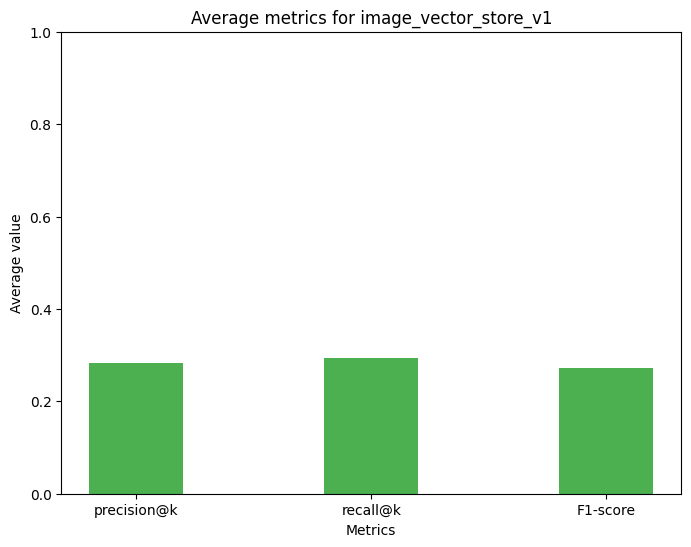

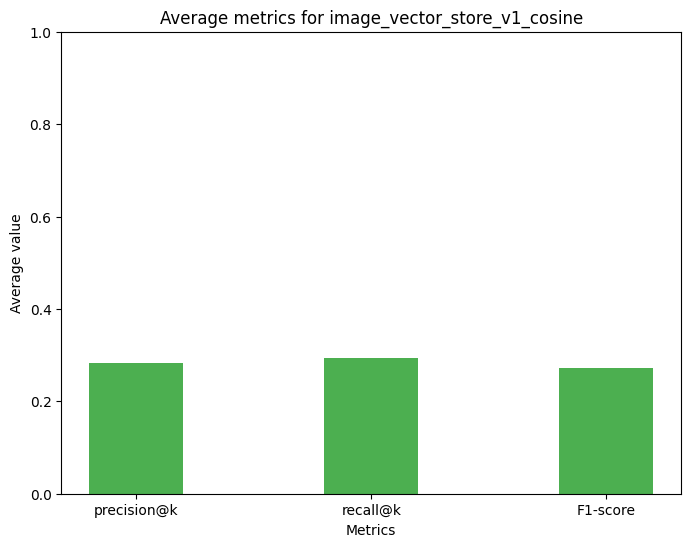

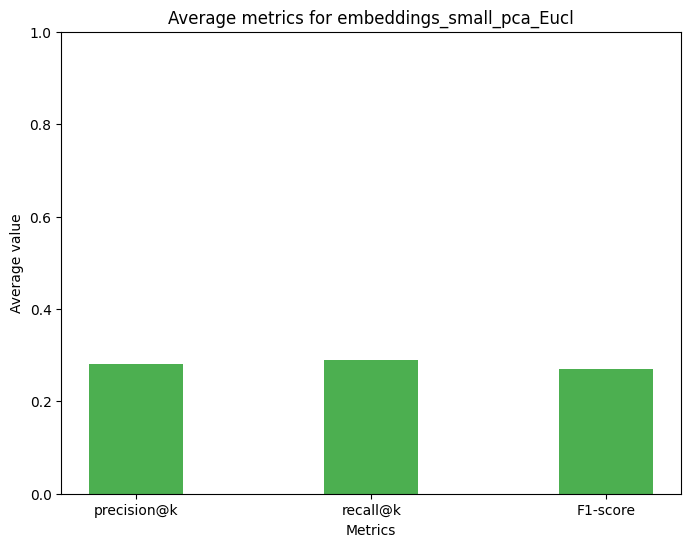

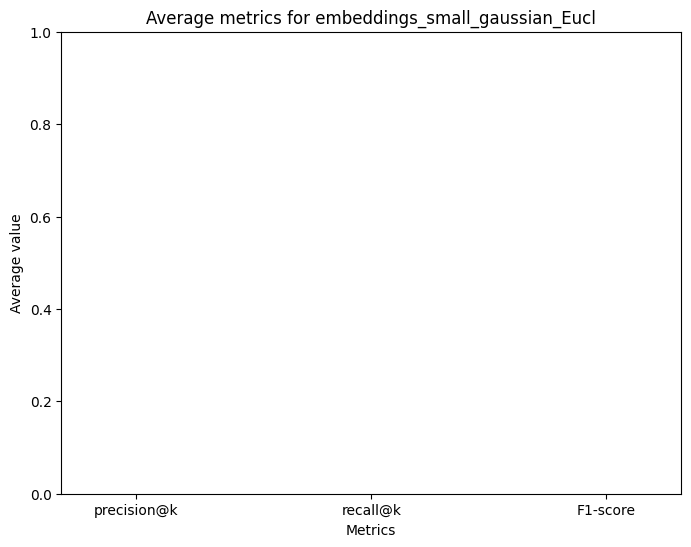

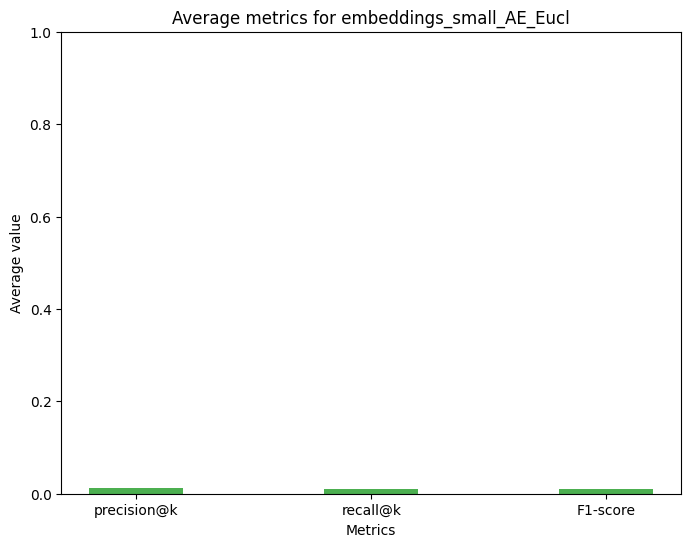

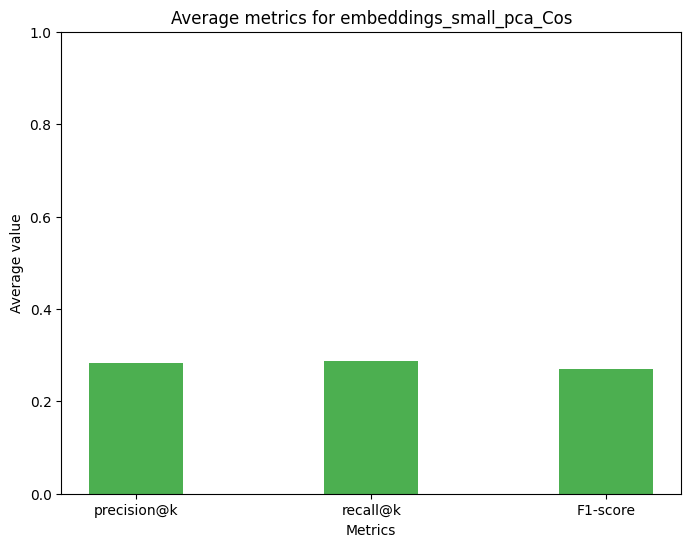

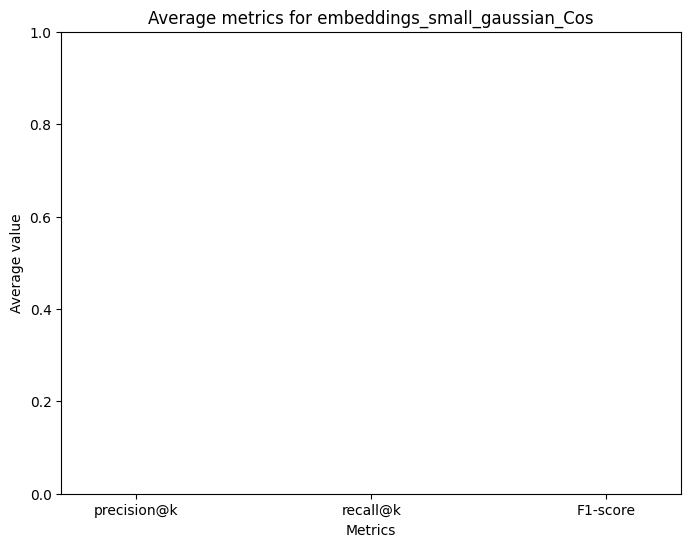

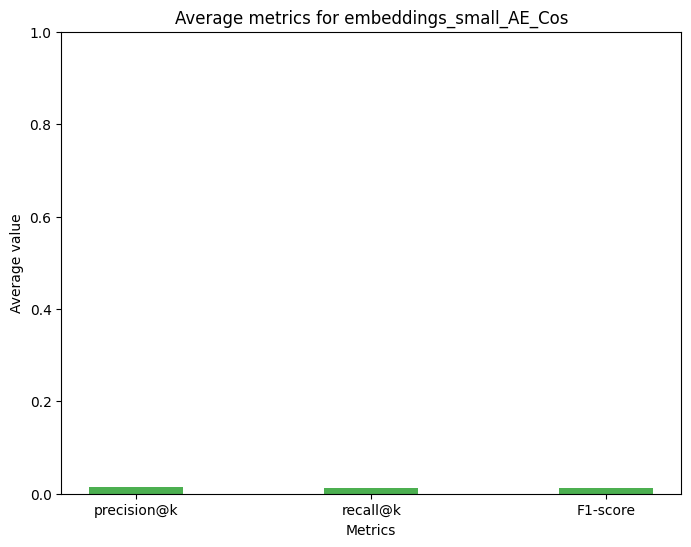

In [132]:
all_names = ["image_vector_store_v1", "image_vector_store_v1_cosine",
    "embeddings_small_pca_Eucl",
    "embeddings_small_gaussian_Eucl",
    "embeddings_small_AE_Eucl",
    "embeddings_small_pca_Cos",
    "embeddings_small_gaussian_Cos",
    "embeddings_small_AE_Cos",
]

for name in all_names:
    plot_average_metrics_per_method(dict_results[name], name)

In [3]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2).fit_transform(data)

In [4]:
tsne_encoder = TSNE(n_components=2).fit_transform(np.load(f"../data/embeddings_small_AE/ae.npy"))

In [5]:
tsne_pca = TSNE(n_components=2).fit_transform(np.load(f"../data/embeddings_small_pca/pca.npy"))

In [6]:
tsne_rand = TSNE(n_components=2).fit_transform(np.load(f"../data/embeddings_small_gaussian/pca.npy"))